# 1. Конкатенация признаков на уровне эмбеддингов (объединение аудио и текстовых признаков в один вектор)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
text_data = pd.read_csv("/content/feature_data.csv")
audio_data = pd.read_csv("/content/audio_data.csv")

### Предобработка

In [3]:
# удаление элементов без аудио-пути
text_data = text_data.dropna(subset=['audio_paths'])
audio_data = audio_data.dropna(subset=['filename'])

# Преобразуем строковые векторы в массивы
text_data['word2vec'] = text_data['word2vec'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
text_data['fasttext'] = text_data['fasttext'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

# Объединяем признаки
text_data['features'] = text_data.apply(lambda row: np.concatenate([row['word2vec'], row['fasttext']]), axis=1)

# Переводим метки в числовой формат
bin_map = {'neut': 0, 'neg': 1, 'pos': 1}
text_data['fin_binery'] = text_data['fin_binery'].map(bin_map)

In [4]:
# Преобразуем строковые векторы в массивы
audio_data['mfcc_mean'] = audio_data['mfcc_mean'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
audio_data['mfcc_std'] = audio_data['mfcc_std'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

# Объединяем признаки
audio_data['features'] = audio_data.apply(lambda row: np.concatenate([row['mfcc_mean'], row['mfcc_std']]), axis=1)

# Переводим метки в числовой формат
bin_map = {'neut': 0, 'neg': 1, 'pos': 1}
audio_data['fin_binery'] = audio_data['fin_binery'].map(bin_map)

### Объединение всех признаков

In [6]:
# объединение нужных колонок из датафреймов в один датафрейм
text_data['filename'] = text_data['audio_paths'].apply(lambda x: x.split('/')[-1])
merged = pd.merge(audio_data[['filename', 'features']],
                  text_data[['filename', 'features', 'fin_binery']],
                  on='filename', suffixes=('_text', '_audio'))

In [7]:
# конкатенация текстовых и аудио признаков
merged['combined_features'] = merged.apply(lambda row: np.concatenate([row['features_text'], row['features_audio']]), axis=1)

### Обучение нейронной сети

Обработка обучающей и тестовой выборку

In [8]:
X = np.stack(merged['combined_features'].values)
y = merged['fin_binery'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=56)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [9]:
# гиперпараметры
hidden_sizes = (64, 32, 16)
learning_rates = 0.0005
batch_sizes = 8

### Обучение модели

In [18]:
def train_model(hidden_layers, lr, batch_size, epochs=50):
    class Net(nn.Module):
        def __init__(self, input_dim):
            super(Net, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(240, hidden_layers[0]),
                nn.ReLU(),
                nn.Linear(hidden_layers[0], hidden_layers[1]),
                nn.Dropout(0.3),
                nn.ReLU(),
                nn.Linear(hidden_layers[1], hidden_layers[2]),
                nn.ReLU(),
                nn.Linear(hidden_layers[2], 3)
            )
        def forward(self, x):
            return self.layers(x)

    model = Net(X.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = {'loss': [], 'acc': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

        history['loss'].append(epoch_loss / len(train_loader))
        history['acc'].append(correct / total)

    return model, history


F1-score: 0.5812



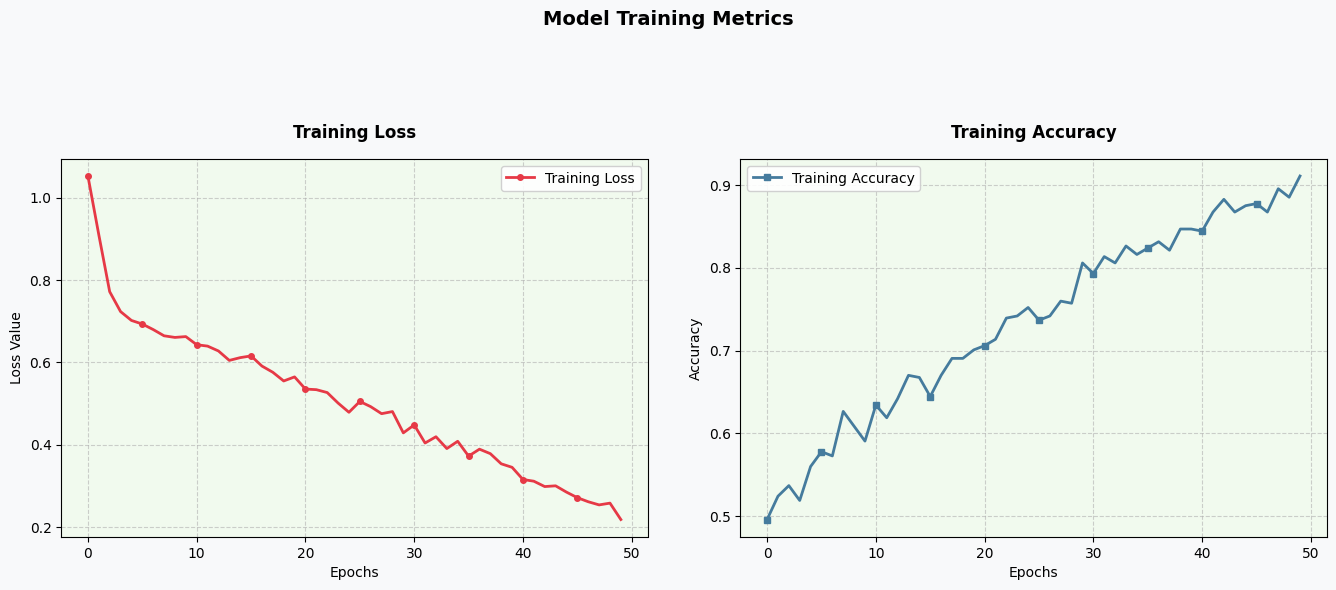


Classification Report:
              precision    recall  f1-score   support

           0     0.6000    0.5882    0.5941        51
           1     0.5625    0.5745    0.5684        47

    accuracy                         0.5816        98
   macro avg     0.5813    0.5814    0.5812        98
weighted avg     0.5820    0.5816    0.5818        98



In [19]:
model, history = train_model(hidden_sizes, learning_rates, batch_sizes)
model.eval()

preds = model(X_test_tensor)
pred_labels = torch.argmax(preds, dim=1).numpy()
f1 = f1_score(y_test, pred_labels, average='macro')

# Вывод F1-score с более читаемым форматированием
print(f"F1-score: {f1:.4f}\n")

# Создаём фигуру с улучшенным оформлением
plt.figure(figsize=(14, 6), facecolor='#f8f9fa')  # Светлый фон

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(history['loss'],
         label='Training Loss',
         color='#e63946',  # Приятный красный
         linewidth=2,
         marker='o',
         markersize=4,
         markevery=5)
plt.title('Training Loss', fontsize=12, pad=15, fontweight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss Value', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(framealpha=0.9, facecolor='white')
plt.gca().set_facecolor('#f1faee')  # Очень светлый зелёный фон

# График точности
plt.subplot(1, 2, 2)
plt.plot(history['acc'],
         label='Training Accuracy',
         color='#457b9d',  # Приятный синий
         linewidth=2,
         marker='s',
         markersize=4,
         markevery=5)
plt.title('Training Accuracy', fontsize=12, pad=15, fontweight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(framealpha=0.9, facecolor='white')
plt.gca().set_facecolor('#f1faee')  # Очень светлый зелёный фон

# Общие настройки
plt.suptitle('Model Training Metrics', fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout(pad=3.0)
plt.show()

# Вывод отчёта с разделителями для лучшей читаемости
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, pred_labels, digits=4))
print("="*50)

# 2. Взвешенное объединение (акцентр на текстовых признаках)

Подготовка данных

In [20]:
def pad_vector(vec, target_len):
    return np.pad(vec, (0, target_len - len(vec)), mode='constant')

# Приведём текстовые признаки к размерности аудио
merged['features_text_padded'] = merged['features_text'].apply(lambda x: pad_vector(x, 200))

In [21]:
alpha = 0.8  # вес текста
merged['combined_features_weighted'] = merged.apply(
    lambda row: alpha * row['features_text_padded'] + (1 - alpha) * row['features_audio'], axis=1
)

### Обучение нейронной сети

In [23]:
X = np.stack(merged['combined_features_weighted'].values)
y = merged['fin_binery'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=56)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [24]:
# гиперпараметры
hidden_sizes = (64, 32, 16)
learning_rates = 0.0005
batch_sizes = 4

In [28]:
def train_model(hidden_layers, lr, batch_size, epochs=50):
    class Net(nn.Module):
        def __init__(self, input_dim):
            super(Net, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(200, hidden_layers[0]),
                nn.ReLU(),
                nn.Linear(hidden_layers[0], hidden_layers[1]),
                nn.Dropout(0.3),
                nn.ReLU(),
                nn.Linear(hidden_layers[1], hidden_layers[2]),
                nn.ReLU(),
                nn.Linear(hidden_layers[2], 3)
            )
        def forward(self, x):
            return self.layers(x)

    model = Net(X.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = {'loss': [], 'acc': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

        history['loss'].append(epoch_loss / len(train_loader))
        history['acc'].append(correct / total)

    return model, history


F1-score: 0.5575



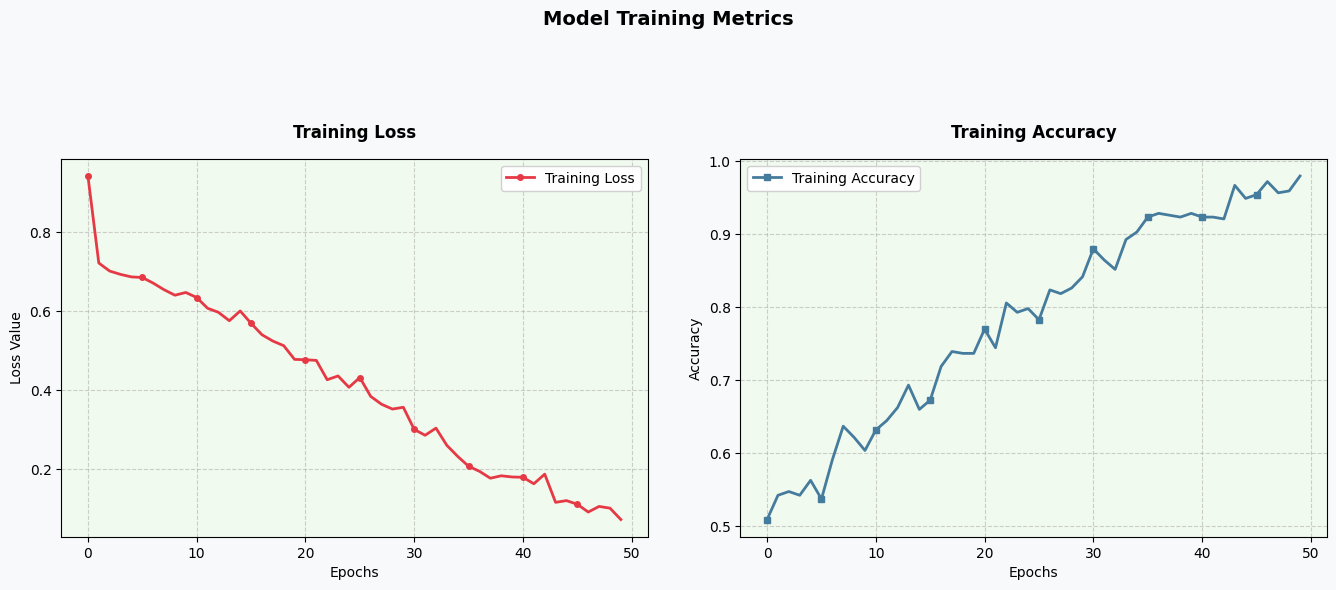


Classification Report:
              precision    recall  f1-score   support

           0     0.5714    0.6275    0.5981        51
           1     0.5476    0.4894    0.5169        47

    accuracy                         0.5612        98
   macro avg     0.5595    0.5584    0.5575        98
weighted avg     0.5600    0.5612    0.5592        98



In [29]:
model, history = train_model(hidden_sizes, learning_rates, batch_sizes)
model.eval()

preds = model(X_test_tensor)
pred_labels = torch.argmax(preds, dim=1).numpy()
f1 = f1_score(y_test, pred_labels, average='macro')

# Вывод F1-score с более читаемым форматированием
print(f"F1-score: {f1:.4f}\n")

# Создаём фигуру с улучшенным оформлением
plt.figure(figsize=(14, 6), facecolor='#f8f9fa')  # Светлый фон

# График функции потерь
plt.subplot(1, 2, 1)
plt.plot(history['loss'],
         label='Training Loss',
         color='#e63946',  # Приятный красный
         linewidth=2,
         marker='o',
         markersize=4,
         markevery=5)
plt.title('Training Loss', fontsize=12, pad=15, fontweight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss Value', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(framealpha=0.9, facecolor='white')
plt.gca().set_facecolor('#f1faee')  # Очень светлый зелёный фон

# График точности
plt.subplot(1, 2, 2)
plt.plot(history['acc'],
         label='Training Accuracy',
         color='#457b9d',  # Приятный синий
         linewidth=2,
         marker='s',
         markersize=4,
         markevery=5)
plt.title('Training Accuracy', fontsize=12, pad=15, fontweight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(framealpha=0.9, facecolor='white')
plt.gca().set_facecolor('#f1faee')  # Очень светлый зелёный фон

# Общие настройки
plt.suptitle('Model Training Metrics', fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout(pad=3.0)
plt.show()

# Вывод отчёта с разделителями для лучшей читаемости
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, pred_labels, digits=4))
print("="*50)